In [1]:
import networkx as nx
# Built-in libraries
import os
import sys
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm
from datetime import datetime, timedelta
from PIL import Image, ImageDraw, ImageFont

# Makerspace libraries
if os.path.isfile('./makerspace.py'): from makerspace import *
#
# else: from helpers.makerspace import *


##############
# timestamps #
##############

def return_unix_time(curr_time, scale=1000):
    ''' converts a string value into a unix timestamp (millisecond) 
        this code works for the following formats:
            - 2022-03-05 12:42:40.133000-05:00
            - 2022-03-23T14:59:56.533Z '''
    if 'T' in curr_time: curr_time = curr_time.replace('T', ' ')
    if 'Z' in curr_time: curr_time = curr_time.replace('Z', '')
    if '-05:00' in curr_time: curr_time = curr_time.replace('-05:00', '') 
    try:    
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S.%f")
        return int(curr_time.timestamp() * scale)
    except Exception as e:
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S")
        return int(curr_time.timestamp() * scale)

def add_unix_time_to_df(df, scale='millisecond'): 
    ''' add a column  that represents the unix time of a dataframe '''
    multiplier = 1
    if scale == 'millisecond': multiplier = 1000
    df['unix'] = df.apply(lambda x: return_unix_time(x['timestamp'],scale=multiplier), axis=1)

def which_hour(curr_time):
    ''' converts a string value into a unix timestamp (millisecond) 
        this code works for the following formats:
            - 2022-03-05 12:42:40.133000-05:00
            - 2022-03-23T14:59:56.533Z '''
    if 'T' in curr_time: curr_time = curr_time.replace('T', ' ')
    if 'Z' in curr_time: curr_time = curr_time.replace('Z', '')
    if '-05:00' in curr_time: curr_time = curr_time.replace('-05:00', '') 
    try:    
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S.%f")
        return curr_time.hour
    except Exception as e:
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S")
        return curr_time.hour

def add_hour_to_df(df):
    df['hour'] = df.apply(lambda x: which_hour(x['timestamp']), axis=1)

def convert_datetime(time_str):
  time_zone = time_str.split('-')[-1]
  time_zone = time_zone.split(':')[0] + time_zone.split(':')[1]
  time_date = time_str.split(' ')[0]
  time_time = time_str.split(' ')[1].split('-')[0]
  reformat_time = '{} {} -{}'.format(time_date,time_time,time_zone)

  try:
    return datetime.strptime(reformat_time, '%Y-%m-%d %H:%M:%S.%f %z')
  except:
    return datetime.strptime(reformat_time, '%Y-%m-%d %H:%M:%S %z')

def obtain_target_times(in_df_student,in_every_sec_freq):
  
  # obtain starting df_freq
  df_freq = in_df_student.copy()
  df_freq.sort_values(by=['timestamp'],inplace=True)
  df_freq.reset_index(inplace=True,drop=True)

  # obtain start_time, end_time and first target_time
  start_time = df_freq.at[0,'timestamp']
  end_time = df_freq.at[len(df_freq)-1,'timestamp']
  target_time = start_time + timedelta(seconds=in_every_sec_freq)

  # obtain target_times
  target_times = [start_time]

  def determine_time_diff(input_time):
    return (input_time - target_time).total_seconds()

  while target_time < end_time:
    df_freq['time_diff'] = df_freq['timestamp'].apply(determine_time_diff)
    df_freq = df_freq[df_freq['time_diff']>=0]
    potential_time = df_freq.at[df_freq['time_diff'].idxmin(),'timestamp']
    if (potential_time - target_time).total_seconds() < in_every_sec_freq:
      target_times.append(potential_time)
    
    target_time = target_time + timedelta(seconds=in_every_sec_freq)

  return target_times

############
# calendar #
############

def add_events(df, cohort): 
    ''' indicate when we had office hours or lab sections '''
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
    df['office'] = df['datetime'].apply(lambda x: cohort.is_office(x))
    df['section'] = df['datetime'].apply(lambda x: cohort.is_section(x))


########################
# Self-touch behaviors #
########################

def add_self_touch(df, threshold=0.1):
    ''' creates a new column called "self_touch" that indicates if the person
        touched his/her face with his/her hand (1) or not (0) for each row '''
    
    df['self_touch'] = df.apply(lambda x: min(
         dist_two_points_3d((x['nose_x'],x['nose_y'],x['nose_z']), 
                            (x['left_wrist_x'],x['left_wrist_y'],x['left_wrist_z'])), 
         dist_two_points_3d((x['nose_x'],x['nose_y'],x['nose_z']), 
                            (x['right_wrist_x'],x['right_wrist_y'],x['right_wrist_z']))), 
    axis=1)
    
    df['self_touch'] = df['self_touch'].apply(lambda x: 1 if x <= threshold else '')


############
# Movement #
############

def add_movement(df, threshold=5, verbose=False):
    
    # assumes that most people won't be moving
    df['is_moving'] = ''
    
    # keep track of the last position for each person
    positions = {}

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    nosex = df['nose_x'].to_numpy()
    nosey = df['nose_y'].to_numpy()
    time = df['datetime']

    # go through the data
    #for i in range(0,df.shape[0]-1):
    for i,v in time.items():

        # get the current time
        curr_time = time[i]
        if type(curr_time) == str: 
            curr_time = datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S")
        person = persons[i]
        if np.isnan([nosex[i],nosey[i]]).any(): continue
        nose = transform_coordinates(nosex[i],nosey[i])

        # check if this person exists
        if person in positions.keys():
            prev_nose = positions[person][1]
            prev_time = positions[person][0]
            if abs(curr_time - prev_time).total_seconds() <= 1:
                dist = dist_two_points(nose,prev_nose)
                df.at[i,'move_dist'] = dist
                if dist < threshold: df.at[i,'is_moving'] = 1

        # update the last seen position
        positions[person] = (curr_time,nose)

        # print progress
        if i % 10000 == 0 and verbose:
            sys.stdout.write("\r")
            sys.stdout.write(str(i) + "/"+str(df.shape[0]))
            sys.stdout.flush()

        
def add_joint_movement(df, joint):
    
    # assumes that most people won't be moving
    df[joint+'_movement'] = ''
    
    # keep track of the last position for each person
    positions = {}

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    joint_x = df[joint+'_x'].to_numpy()
    joint_y = df[joint+'_y'].to_numpy()
    joint_z = df[joint+'_z'].to_numpy()
    time = df['datetime']

    # go through the data
    for i,v in time.items():

        # get the current time
        curr_time = time[i]
        if type(curr_time) == str: 
            curr_time = datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S")
        person = persons[i]
        if np.isnan([joint_x[i],joint_y[i]]).any(): continue
        jointxyz = joint_x[i],joint_y[i],joint_z[i]

        # check if this person exists
        if person in positions.keys():
            prev_joint = positions[person][1]
            prev_time = positions[person][0]
            if abs(curr_time - prev_time).total_seconds() <= 1:
                dist = dist_two_points_3d(jointxyz,prev_joint) * 90
                df.at[i,joint+'_movement'] = dist

        # update the last seen position
        positions[person] = (curr_time,jointxyz)
       


            
def add_two_joints_movement(df, joint1, joint2):
    
    # find joint name
    joint_name = joint1.replace('right_','').replace('left_','')
    df[joint_name+'_movement'] = ''
    
    # keep track of the last position for each person
    positions = {}

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    lx,ly,lz = df[joint1+'_x'].to_numpy(),df[joint1+'_y'].to_numpy(),df[joint1+'_z'].to_numpy()
    rx,ry,rz = df[joint2+'_x'].to_numpy(),df[joint2+'_y'].to_numpy(),df[joint2+'_z'].to_numpy()
    time = df['datetime']

    # go through the data
    for i,v in time.items():

        # get the current time
        curr_time = time[i]
        if type(curr_time) == str: 
            curr_time = datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S")
        person = persons[i]
        if np.isnan([lx[i],ly[i],lz[i],rx[i],ry[i],rz[i]]).any(): continue
        l = lx[i],ly[i],lz[i]
        r = rx[i],ry[i],rz[i]

        # check if this person exists
        if person in positions.keys():
            prev_l,prev_r = positions[person][1],positions[person][2]
            prev_time = positions[person][0]
            if abs(curr_time - prev_time).total_seconds() <= 1:
                dist = dist_two_points_3d(l,prev_l)+dist_two_points(r,prev_r)
                df.at[i,joint_name+'_movement'] = dist * 90

        # update the last seen position
        positions[person] = (curr_time,l,r)
    
        
########################
# social Interactions  #
########################

def add_social_interactions(df, threshold=100, verbose=False):
    ''' add two columns: 'state', which indicates someone that the person is close to;
        and 'is_oriented_toward', which indicates someone who is close and where 
        their lines of sight (orthogonal from shoulders to nose) intersect'''

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    lshoulderx = df['left_shoulder_x'].to_numpy()
    lshouldery = df['left_shoulder_y'].to_numpy()
    rshoulderx = df['right_shoulder_x'].to_numpy()
    rshouldery = df['right_shoulder_y'].to_numpy()
    nosex = df['nose_x'].to_numpy()
    nosey = df['nose_y'].to_numpy()
    time = df['datetime'].to_numpy()

    # go through the data
    for i in range(0,df.shape[0]-1):

        # get the data
        t = time[i]
        if np.isnan([nosex[i],nosey[i]]).any(): continue
        hx = (lshoulderx[i]+rshoulderx[i])/2.0
        hy = (lshouldery[i]+rshouldery[i])/2.0
        head = transform_coordinates(hx,hy)
        nose = transform_coordinates(nosex[i],nosey[i])

        # check the next entries
        j = i+1
        while(time[j] == time[i] and j < df.shape[0]-1):

            # check if we have data
            if not np.isnan([nosex[j],nosey[j]]).any(): 
                nosej = transform_coordinates(nosex[j],nosey[j])
                
                # close proximity
                if dist_two_points(nose,nosej) < threshold: 
                    
                    # create a column to keep track of the other person
                    df.at[i,'state'] = persons[j]

                    # check body orientation
                    hxj = (lshoulderx[j]+rshoulderx[j])/2.0
                    hyj = (lshouldery[j]+rshouldery[j])/2.0
                    headj = transform_coordinates(hxj,hyj)
                    gaze1 = compute_gaze(head,nose)
                    gaze2 = compute_gaze(headj,nosej)
                    if intersect(gaze1,gaze2) != None: 
                        df.at[i,'is_oriented_toward'] = persons[j]

                    
            # check the next row
            j += 1

        # print progress
        if i % 10000 == 0 and verbose:
            sys.stdout.write("\r")
            sys.stdout.write(str(i) + "/"+str(df.shape[0]))
            sys.stdout.flush()
            
#Removes Rows with certain values (like unidentified)
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [2]:
from matplotlib.colors import ListedColormap
#next(Data, None)  # skip the first line in the input file
#Data Import
#dat = pd.read_csv('2022-01-27-features.csv')

# Get CSV files list from a folder
path = 'data_folder'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
dat   = pd.concat(df_list, ignore_index=True)




C:\Users\louis\AppData\Local\Temp\ipykernel_2448\866862961.py:12: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_2448\866862961.py:12: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_2448\866862961.py:12: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_2448\866862961.py:12: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_2448\866862961.py:12: DtypeWarning: Columns (14,15,16) have 

In [3]:
dat[['Date', 'Time']] = dat['datetime'].str.split(' ', expand=True, regex=False)
print(dat)


#Weekframes:
#dat['Date'] = dat['Date'].apply(pd.to_datetime)
#print('done convert')
#weeks = [g for n, g in dat.groupby(pd.Grouper(key='Date', freq='W', dropna=True))]

        person_identity             datetime            aoi  is_moving  \
0                  rhea  2022-01-27 09:00:01  collaboration        NaN   
1          unidentified  2022-01-27 09:00:01  collaboration        NaN   
2                  yani  2022-01-27 09:00:01  collaboration        NaN   
3               melissa  2022-01-27 09:00:01  collaboration        NaN   
4               natalie  2022-01-27 09:00:01  collaboration        NaN   
...                 ...                  ...            ...        ...   
6750996          conner  2022-05-05 02:00:01  collaboration        1.0   
6750997    unidentified  2022-05-05 02:00:01  collaboration        NaN   
6750998            rhea  2022-05-05 02:00:01  collaboration        NaN   
6750999            sara  2022-05-05 02:00:01          laser        NaN   
6751000            yani  2022-05-05 02:00:01  collaboration        1.0   

         move_dist  left_knee_angle  right_knee_angle  standing  \
0              NaN        53.483247         

In [4]:
#dat.info()
dat['Date'] = pd.to_datetime(dat['Date'])
#dat.info()

#SEPARATE BY WEEK
#weeks = [g for n, g in dat.groupby(pd.Grouper(key='Date', freq='W', dropna=True))]

#SEPARATE BY PERIODS
# P1 : 2022-01-27 to 2022-02-16 SMALL PROJECT
# P2 : 2022-02-17 to 2022-03-20 BIG PROJECT
# P3 : 2022-03-21 to 2022-04-07 BREAK
# P4 : 2022-04-08 to 2022-04-14 SMALL PROJECT
# P5 : 2022-04-15 to END FINAL PROJECT
datacop1 = dat.copy()
date_1 = datetime.strptime('2022-01-27', '%Y-%m-%d')
date_2 = datetime.strptime('2022-02-16', '%Y-%m-%d')
date_3 = datetime.strptime('2022-02-17', '%Y-%m-%d')
date_4 = datetime.strptime('2022-03-20', '%Y-%m-%d')
date_5 = datetime.strptime('2022-03-21', '%Y-%m-%d')
date_6 = datetime.strptime('2022-04-07', '%Y-%m-%d')
date_7 = datetime.strptime('2022-04-08', '%Y-%m-%d')
date_8 = datetime.strptime('2022-04-14', '%Y-%m-%d')
date_9 = datetime.strptime('2022-04-15', '%Y-%m-%d')

datacop1 = datacop1[(datacop1['Date'] >= date_1) & (datacop1['Date'] <= date_2)]
datacop2 = dat.copy()
datacop2 = datacop2[(datacop2['Date'] >= date_3) & (datacop2['Date'] <= date_4)]
datacop3 = dat.copy()
datacop3 = datacop3[(datacop3['Date'] >= date_5) & (datacop3['Date'] <= date_6)]
datacop4 = dat.copy()
datacop4 = datacop4[(datacop4['Date'] >= date_7) & (datacop4['Date'] <= date_8)]
datacop5 = dat.copy()
datacop5 = datacop5[(datacop5['Date'] >= date_9)]

periods = [datacop1, datacop2, datacop3, datacop4, datacop5]
weeks = periods.copy()

#months = [g for n, g in dat.groupby(pd.Grouper(key='Date', freq='M', dropna=True))]

In [5]:
print(weeks[1])

        person_identity             datetime            aoi  is_moving  \
1461951            alaa  2022-02-17 11:59:58      soldering        NaN   
1461952          iulian  2022-02-17 11:59:58      soldering        NaN   
1461953          daniel  2022-02-17 11:59:58  collaboration        NaN   
1461954          daniel  2022-02-17 11:59:59  collaboration        NaN   
1461955          iulian  2022-02-17 11:59:59      soldering        1.0   
...                 ...                  ...            ...        ...   
3277112    unidentified  2022-03-20 16:59:57  collaboration        1.0   
3277113    unidentified  2022-03-20 16:59:58  collaboration        1.0   
3277114    unidentified  2022-03-20 16:59:59  collaboration        1.0   
3277115    unidentified  2022-03-20 17:00:00  collaboration        1.0   
3277116    unidentified  2022-03-20 17:00:01  collaboration        1.0   

         move_dist  left_knee_angle  right_knee_angle  standing  \
1461951        NaN       140.202129        1

In [6]:
orientation_state = 1 # 0 = is_with, 1 = is_oriented_toward
if(orientation_state == 0):
    state = 'is_with'
else:
    state = 'is_oriented_toward'

In [7]:
#Data Filtering
#time_in_mks_dat = dat
#time_in_mks_dat = time_in_mks_dat[time_in_mks_dat.person_identity != 'unidentified']
#time_in_mks_dat = time_in_mks_dat.groupby(['person_identity']).size().reset_index(name='time_in_mks')
#print(time_in_mks_dat)

#filtered_dat = dat[dat.is_oriented_toward != 'unidentified']
#filtered_dat = filtered_dat[filtered_dat.person_identity != 'unidentified']
#filtered_dat = filtered_dat[filtered_dat.person_identity != filtered_dat.is_oriented_toward]

#grouped_data=filtered_dat.groupby(['person_identity','is_oriented_toward']).size().reset_index(name='is_with_count')
#grouped_data = grouped_data[grouped_data.is_with_count > 3]
#grouped_data['is_with_count_ln2'] = np.log2(grouped_data['is_with_count'])

#print(grouped_data)

def datafilter(data, state):
    data_cop = data.copy()
    time_in_mks_dat = data_cop
    time_in_mks_dat = time_in_mks_dat[time_in_mks_dat.person_identity != 'unidentified']
    time_in_mks_dat = time_in_mks_dat.groupby(['person_identity']).size().reset_index(name='time_in_mks')
    #print(time_in_mks_dat)
    if(state == 'is_oriented_toward'):
        data_cop = data_cop[data_cop.is_oriented_toward != 'unidentified']
        data_cop = data_cop[data_cop.person_identity != 'unidentified']
        data_cop = data_cop[data_cop.person_identity != data_cop.is_oriented_toward]
        grouped_data = data.groupby(['person_identity','is_oriented_toward']).size().reset_index(name='is_with_count')
        grouped_data = grouped_data.merge(time_in_mks_dat, left_on='person_identity', right_on='person_identity')
        #grouped_data = grouped_data[grouped_data.is_with_count > 3]
    if(state == 'is_with'):
        data_cop = data_cop[data_cop.is_with != 'unidentified']
        data_cop = data_cop[data_cop.person_identity != 'unidentified']
        data_cop = data_cop[data_cop.person_identity != data_cop.is_with]
        grouped_data = data_cop.groupby(['person_identity','is_with']).size().reset_index(name='is_with_count')
        grouped_data = grouped_data.merge(time_in_mks_dat, left_on='person_identity', right_on='person_identity')
        #grouped_data = grouped_data[grouped_data.is_with_count > 3]
        print(grouped_data)
    return grouped_data

grouped_data = datafilter(dat, state)


In [8]:
#for week in weeks:
#    week=datafilter(week, state)
#    print(week, '\n', '\n')
    
filtered_weeks = [datafilter(week, state) for week in weeks]
print(filtered_weeks[1])

for all in filtered_weeks:
    for each in all:
        for each2 in all:
            print(each, each2[1])
            if (each == each2[1] and (each[1] == each2[0])):
                print(each(person_identity), each2(is_oriented_toward), each(is_with_count)-each2(is_with_count))
            
        

#for month in months:
#    month=datafilter(month)

#filtered_months= [datafilter(month, state) for month in months]
    

    person_identity is_oriented_toward  is_with_count  time_in_mks
0            aashna             aashna              1        11858
1            aashna           bertrand              2        11858
2            aashna             daniel            309        11858
3            aashna             iulian            157        11858
4            aashna               marc              1        11858
..              ...                ...            ...          ...
290            yani                rui             11        90150
291            yani               sara            860        90150
292            yani       unidentified            138        90150
293            yani             xiaoyi             15        90150
294            yani               yani              3        90150

[295 rows x 4 columns]
person_identity e
person_identity s
person_identity s
person_identity i
is_oriented_toward e
is_oriented_toward s
is_oriented_toward s
is_oriented_toward i
is_with_count e


In [9]:

def add_time_spent_to_group(Group, dataset, list_ta, list_student):
    time_spent_dat1 = dataset.copy().groupby(['person_identity'])['is_with_count'].sum().reset_index(name='time_spent')
    time_spent_dat2 = dataset.copy().groupby([state])['is_with_count'].sum().reset_index(name='time_spent')
    time_spent_dat2.rename(columns={state:'person_identity'}, inplace=True)
    time_spent_dat1.set_index('person_identity').to_dict()['time_spent']
    time_spent_dat2.set_index('person_identity').to_dict()['time_spent']
    
    time_spent_anal = pd.concat([time_spent_dat1, time_spent_dat2])
    time_spent_ta = time_spent_anal.copy()
    time_spent_student = time_spent_anal.copy()
    time_spent_ta = time_spent_ta[time_spent_ta.person_identity.isin(list_ta)]
    time_spent_student = time_spent_student[time_spent_student.person_identity.isin(list_student)]
    time_spent_ta = time_spent_ta.groupby(['person_identity'])['time_spent'].sum().reset_index(name='time_spent_with_ta')
    time_spent_student = time_spent_student.groupby(['person_identity'])['time_spent'].sum().reset_index(name='time_spent_with_student')
    
    time_spent_dat = pd.concat([time_spent_dat1, time_spent_dat2]).groupby(['person_identity'])['time_spent'].sum().reset_index(name='time_spent_with')
    
    time_in_mks_dat = dataset
    time_in_mks_dat = time_in_mks_dat.merge(time_spent_dat, left_on='person_identity', right_on='person_identity')
    time_in_mks_dat['pct_time_in_mks_with'] = time_in_mks_dat['time_spent_with']/time_in_mks_dat['time_in_mks']
    node_t_s_2 = time_in_mks_dat.set_index('person_identity').to_dict()['time_in_mks']
    #print("Time : ", node_t_s_2)
    nx.set_node_attributes(Group, node_t_s_2, 'time_in_mks')
    node_t_s = time_in_mks_dat.set_index('person_identity').to_dict()['pct_time_in_mks_with']
    #print("Nodes : ", node_t_s)
    #print("% : ", node_t_s)
    nx.set_node_attributes(Group, node_t_s, 'time_spent_with')
    
    node_t_s_3 = time_spent_ta.set_index('person_identity').to_dict()['time_spent_with_ta']
    
    nx.set_node_attributes(Group, node_t_s_3, 'time_spent_with_ta')
    
    node_t_s_4 = time_spent_student.set_index('person_identity').to_dict()['time_spent_with_student']
    nx.set_node_attributes(Group, node_t_s_4, 'time_spent_with_student')
    
    return Group

def add_time_spent_in_mks_to_group(Group, dataset):
    time_spent_dat = dataset     
    node_t_s = time_spent_dat.set_index('person_identity').to_dict()['time_in_mks']
    #print("Nodes : ", node_t_s)
    nx.set_node_attributes(Group, node_t_s, 'time_in_mks')
    return Group

def dataplot(Group, name):
    btc = nx.betweenness_centrality(Group)
    tim_spent = []
    tim_spent_with = []
    for all in Group.nodes():
        #print(all, " : ", Group.nodes[all])
        #if(Group.nodes[all].empty()):
        #    Group.remove_node(all)
        #else:
        tim_spent.append(nx.get_node_attributes(Group, 'time_in_mks')[all])
        tim_spent_with.append(nx.get_node_attributes(Group, 'time_spent_with')[all])
    cmap = plt.get_cmap('cool')
    cmap2 = plt.get_cmap('viridis')
    d = dict(nx.degree(Group))
    pos = nx.spring_layout(Group, k=2, weight='is_with_count')
    print('edges: ', nx.number_of_edges(Group))
    print('nodes: ', nx.number_of_nodes(Group))
    if (nx.number_of_edges(Group) < 1):
        nx.draw(Group, node_size=[v for v in tim_spent ])
        return
    node_size_factor = 1000/max([v for v in tim_spent])
    width_size_factor = 10/(np.sqrt(max([e[2]['is_with_count'] for e in Group.edges(data=True)])))
    #print(np.sqrt(max([e[2]['is_with_count'] for e in Group.edges(data=True)])), " vs : ", np.sqrt(np.average([e[2]['is_with_count'] for e in Group.edges(data=True)])))
    nx.draw(Group, pos, node_size=[v*node_size_factor for v in tim_spent], 
            cmap = cmap, vmin = min([b for b in tim_spent_with]), vmax = max([b for b in tim_spent_with]), #min(btc.values()), vmax = max(btc.values()), 
            node_color=[b for b in tim_spent_with],#[b for b in btc.values()], 
            edge_cmap = cmap2, 
            edge_color = [e[2]['is_with_count'] for e in Group.edges(data=True)], with_labels=True, 
            edge_vmin = min([e[2]['is_with_count'] for e in Group.edges(data=True)]), 
            edge_vmax = max([e[2]['is_with_count'] for e in Group.edges(data=True)]),
            width = [width_size_factor*np.sqrt(e[2]['is_with_count']) for e in Group.edges(data=True)])
    #cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([b for b in tim_spent_with]),vmax=max([b for b in tim_spent_with])),cmap=cmap), extend='both', orientation='vertical', label = 'Time Spent With Others', ax=None)
    #cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in Group.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in Group.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')
    plt.savefig(name)
    

In [10]:
#Creating Overall Metrics Dataset
G_overall = nx.from_pandas_edgelist(grouped_data, source='person_identity', target=state, edge_attr=['is_with_count'])
nodelist = nx.nodes(G_overall)
print(nodelist)
df_nodes = pd.DataFrame(nodelist, columns=['person_identity'])
#df_nodes['week_number'] = 0
df_nodes.head()
#df_nodes.set_index('person_identity', inplace=True)
df_nodes_copy = df_nodes.copy()

#df_nodes_copy.set_index('person_identity', inplace=True)
print(df_nodes_copy)

['aashna', 'alaa', 'bertrand', 'chali', 'conner', 'daniel', 'helen', 'hoa', 'iulian', 'ji su', 'juan', 'marc', 'melissa', 'miaoya', 'natalie', 'rachel', 'rebecca', 'rhea', 'rui', 'sara', 'unidentified', 'xiaoyi', 'yani', 'denise']
   person_identity
0           aashna
1             alaa
2         bertrand
3            chali
4           conner
5           daniel
6            helen
7              hoa
8           iulian
9            ji su
10            juan
11            marc
12         melissa
13          miaoya
14         natalie
15          rachel
16         rebecca
17            rhea
18             rui
19            sara
20    unidentified
21          xiaoyi
22            yani
23          denise


In [11]:
#Label Students vs. TAs

df_students = ['aashna','chali','conner','denise','helen','hoa','ji su','juan','melissa','miaoya','natalie','rachel','rebecca','rhea','rui','sara','xiaoyi','yani']
df_tas = []
for names in df_nodes_copy['person_identity']:
    if names not in df_students:
        df_tas.append(names)
print(df_tas)

['alaa', 'bertrand', 'daniel', 'iulian', 'marc', 'unidentified']


In [12]:
def max_edge_weight_for_node(G, node):
    #print('Node :', node)
    if(G.degree[node] == 0):
        G.nodes[node]['max_edge_weight_student'] = 0
        G.nodes[node]['max_edge_weight_ta'] = 0
        return
    max_edge_weight_student = 0
    max_edge_weight_ta = 0
    for each in G.edges(node, data=True):
        #print('Edges : ', each)
        #print('Node to : ', each[1])
        #print('Status : ', nx.get_node_attributes(G,'status')[each[1]])
        if(nx.get_node_attributes(G,'status')[each[1]]=='student'):
            if(each[2]['is_with_count'] > max_edge_weight_student):
                max_edge_weight_student = each[2]['is_with_count']
        if(nx.get_node_attributes(G,'status')[each[1]]=='ta'):
            if(each[2]['is_with_count'] > max_edge_weight_ta):
                max_edge_weight_ta = each[2]['is_with_count']
    G.nodes[node]['max_edge_weight_student'] = max_edge_weight_student
    G.nodes[node]['max_edge_weight_ta'] = max_edge_weight_ta
    print('Max Edges : ', max_edge_weight_student, ' , ', max_edge_weight_ta)
    print('Double Check : ', nx.get_node_attributes(G,'max_edge_weight_student')[node], ' , ', nx.get_node_attributes(G,'max_edge_weight_ta')[node])


Max Edges :  1676  ,  988
Double Check :  1676  ,  988
Max Edges :  257  ,  168
Double Check :  257  ,  168
Max Edges :  269  ,  586
Double Check :  269  ,  586
Max Edges :  833  ,  557
Double Check :  833  ,  557
Max Edges :  988  ,  223
Double Check :  988  ,  223
Max Edges :  586  ,  223
Double Check :  586  ,  223
Max Edges :  1118  ,  88
Double Check :  1118  ,  88
Max Edges :  1118  ,  824
Double Check :  1118  ,  824
Max Edges :  386  ,  217
Double Check :  386  ,  217
Max Edges :  1005  ,  56
Double Check :  1005  ,  56
Max Edges :  184  ,  290
Double Check :  184  ,  290
Max Edges :  184  ,  516
Double Check :  184  ,  516
Max Edges :  1676  ,  394
Double Check :  1676  ,  394
Max Edges :  1228  ,  0
Double Check :  1228  ,  0
Max Edges :  1005  ,  179
Double Check :  1005  ,  179
Max Edges :  878  ,  87
Double Check :  878  ,  87
Max Edges :  2092  ,  189
Double Check :  2092  ,  189
Max Edges :  546  ,  577
Double Check :  546  ,  577
Max Edges :  1228  ,  318
Double Check :

edges:  79
nodes:  23
Added :                   betweenness_centrality  degree  max_edge_weight_ta  \
person_identity                                                       
aashna                         0.019930     7.0               988.0   
alaa                           0.016411     6.0               168.0   
chali                          0.015777     7.0               586.0   
conner                         0.020988     7.0               557.0   
daniel                         0.244523    18.0               223.0   
iulian                         0.050003    10.0               223.0   
ji su                          0.022013     8.0                88.0   
juan                           0.036521     7.0               824.0   
marc                           0.025740     8.0               217.0   
melissa                        0.006433     5.0                56.0   
miaoya                         0.007187     5.0               290.0   
natalie                        0.004226     4.

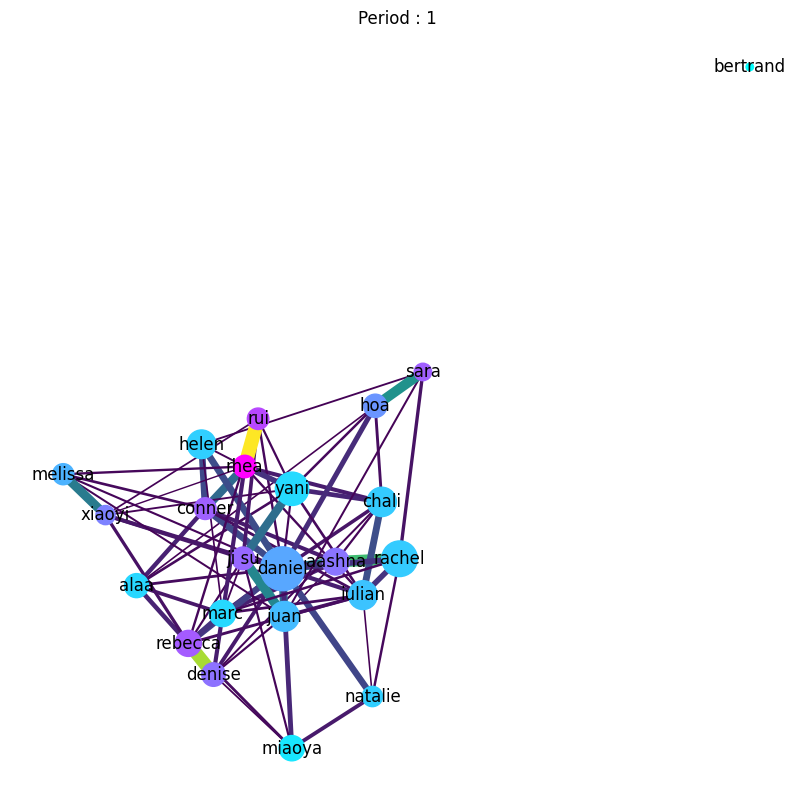

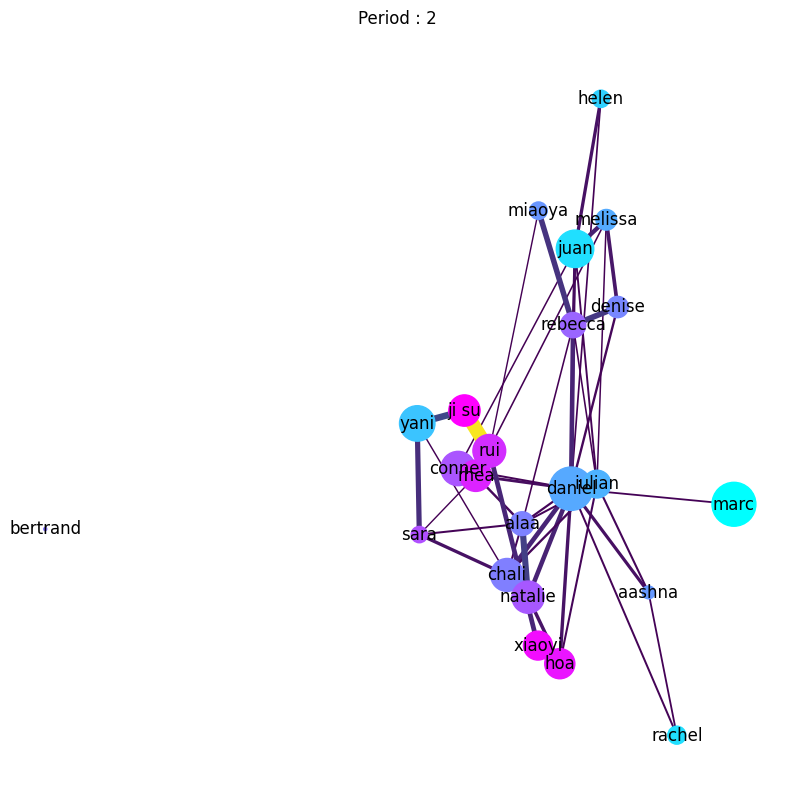

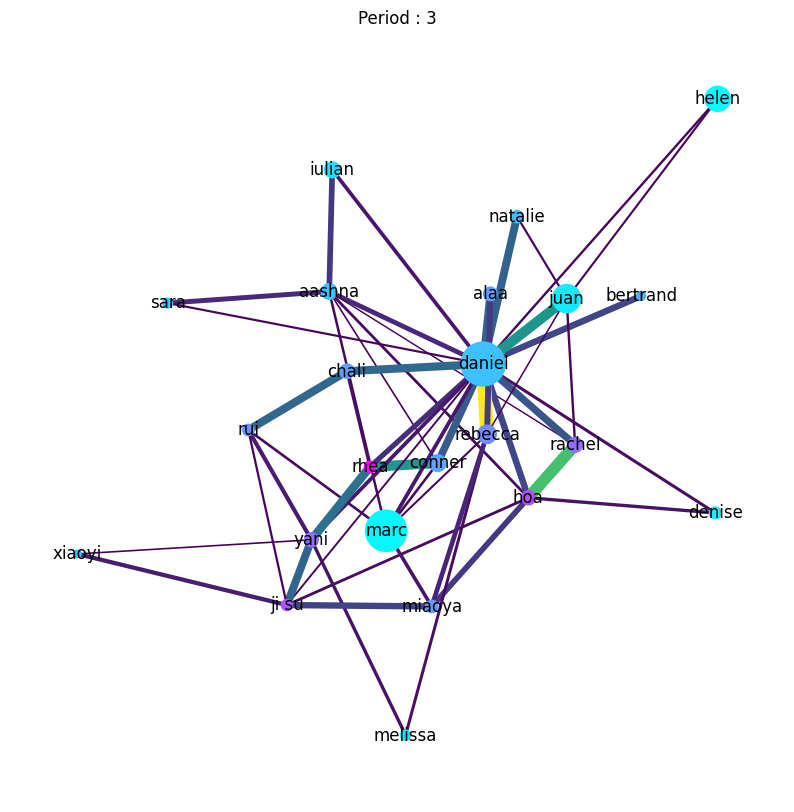

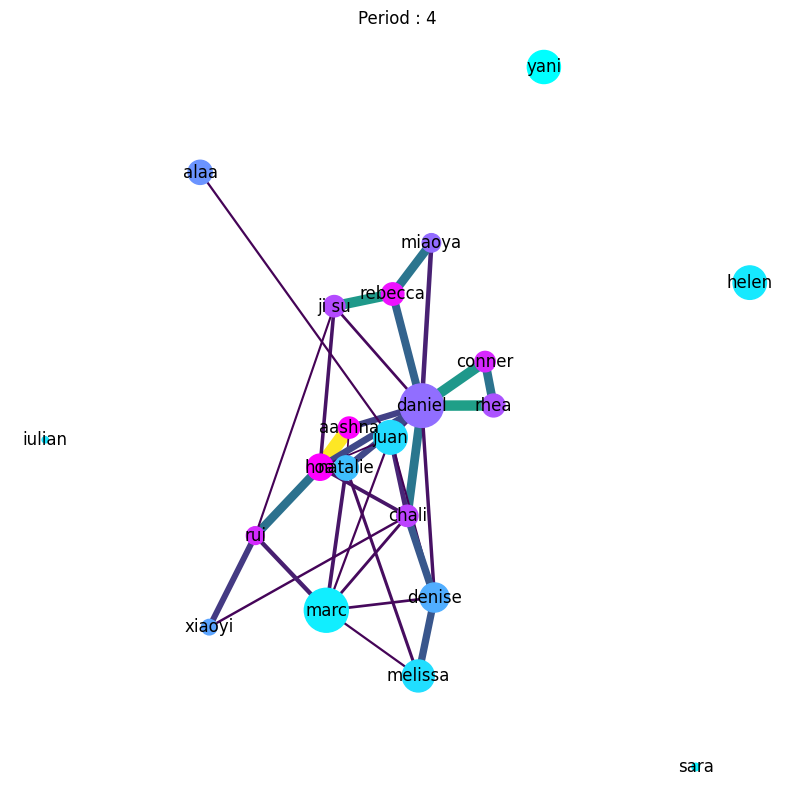

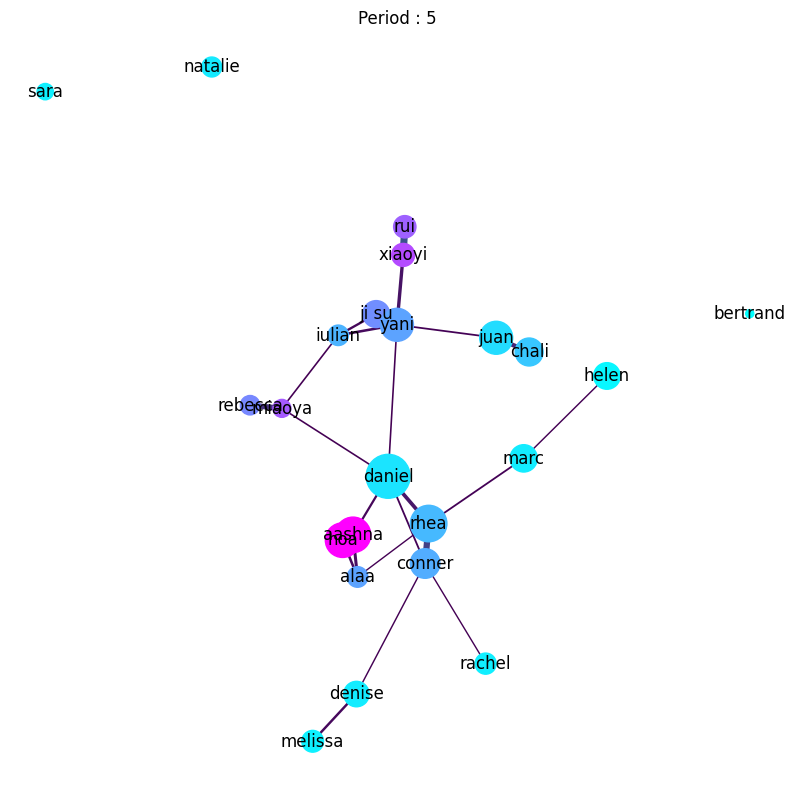

In [13]:
n = 0
check = 0
df_nodes = df_nodes_copy
for week in filtered_weeks:
    n=n+1
    if(week.empty):
        continue
    if(week.shape[0] < 3):
        continue
    #if(n > 3):
        #continue
    Graphtype = nx.Graph()
    G = nx.from_pandas_edgelist(week, create_using=Graphtype, source='person_identity', target=state, edge_attr='is_with_count')
    max_count = max([e[2]['is_with_count'] for e in G.edges(data=True)])
    to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs['is_with_count'] <= 0.01*max_count]
    G.remove_edges_from(to_remove)
    G2 = add_time_spent_to_group(G, week, df_tas, df_students)
    nodes_to_remove = []
    #nodes_to_remove = [n for n, attrs in G.nodes(data=True) if attrs['time_in_mks']<50]
    #print("Removing : ", nodes_to_remove)
    #G.remove_nodes_from(nodes_to_remove)
    tim_spent = []
    for all in G2.nodes(data='time_in_mks', default=0):
        if(all[1]==0):
            nodes_to_remove.append(all[0])
    G2.remove_nodes_from(nodes_to_remove)
    for all in nx.get_node_attributes(G2, 'time_spent_in_mks'):
        tim_spent.append(nx.get_node_attributes(G2, 'time_spent_in_mks')[all])
    tim_sp = nx.get_node_attributes(G2, 'time_spent_in_mks')
    if(nx.number_of_nodes(G2) < 2):
        continue
    #NETWORK MEASURES:
    #Week Number
    nx.set_node_attributes(G2, n, 'week_number')

    
    df_weekly_join = df_nodes_copy
    for all in G2.nodes():
        if(all in df_students):
            #print('Student : ', all)
            G2.nodes[all]['status'] = 'student'
        elif(all in df_tas):
            #print('TA : ', all)
            G2.nodes[all]['status'] = 'ta'
        #else:
            #print('Unknown : ', all)
    for node in G2.nodes():
        max_edge_weight_for_node(G2, node)
    #Betweenness Centrality
    btc = nx.betweenness_centrality(G2)
    nx.set_node_attributes(G2, btc, 'betweenness_centrality')
        
    #Degree Centrality
    degc = nx.degree_centrality(G2)
    nx.set_node_attributes(G2, degc, 'degree_centrality')
    
    #Degrees
    deg_list = dict(G2.degree())
    #print('Deg_list : ', deg_list)
    nx.set_node_attributes(G2, deg_list, 'degree')
    
    
    week_nodelist = nx.nodes(G2)
    #print(nx.get_node_attributes(G2, 'betweenness_centrality'))
    list_btc = list(btc.values())
    #print('Btc values : ', list_btc)
    #print('Week Nodelist : ', week_nodelist)
    dict_centrality = nx.get_node_attributes(G2, 'betweenness_centrality')
    dict_degree = nx.get_node_attributes(G2, 'degree')
    dict_degree_centrality = nx.get_node_attributes(G2, 'degree_centrality')
    dict_max_edge_weight_ta = nx.get_node_attributes(G2, 'max_edge_weight_ta')
    dict_max_edge_weight_student = nx.get_node_attributes(G2, 'max_edge_weight_student')
    #print(dict_degree)
    df_weekly_ce = pd.DataFrame.from_dict(dict_centrality, orient='index', columns=['betweenness_centrality'])
    df_weekly_ce.rename_axis('person_identity', inplace=True)
    df_weekly_de = pd.DataFrame.from_dict(dict_degree, orient='index', columns=['degree'])
    df_weekly_de.rename_axis('person_identity', inplace=True)
    df_weekly_max_edge_weight_ta = pd.DataFrame.from_dict(dict_max_edge_weight_ta, orient='index', columns=['max_edge_weight_ta'])
    df_weekly_max_edge_weight_ta.rename_axis('person_identity', inplace=True)
    df_weekly_max_edge_weight_student = pd.DataFrame.from_dict(dict_max_edge_weight_student, orient='index', columns=['max_edge_weight_student'])
    df_weekly_max_edge_weight_student.rename_axis('person_identity', inplace=True)
    #df_weekly_de_ce = pd.DataFrame.from_dict(dict_degree_centrality, orient='index', columns=['degree_centrality'])
    #df_weekly_de_ce.head()
    
    df_weekly = df_weekly_ce.merge(df_weekly_de, left_on='person_identity', right_on='person_identity')
    df_weekly = df_weekly.merge(df_weekly_max_edge_weight_ta, left_on='person_identity', right_on='person_identity')
    df_weekly = df_weekly.merge(df_weekly_max_edge_weight_student, left_on='person_identity', right_on='person_identity')
    #df_weekly = df_weekly.merge(df_weekly_de_ce, left_on='person_identity', right_on='person_identity')
    df_weekly['week_number'] = n
    print("Week : ", df_weekly)


    df_weekly_join = df_weekly.join(df_weekly_join.set_index('person_identity'), on='person_identity', how='left')
    df_weekly_join.fillna(0, inplace=True)
    df_weekly_join['week_number'] = n
    df_weekly_join['betweenness_centrality'] = df_weekly_join['betweenness_centrality'].astype(float)
    df_weekly_join['degree'] = df_weekly_join['degree'].astype(float)
    df_weekly_join['max_edge_weight_ta'] = df_weekly_join['max_edge_weight_ta'].astype(float)
    df_weekly_join['max_edge_weight_student'] = df_weekly_join['max_edge_weight_student'].astype(float)
    #print('Empty Joined: ', df_weekly_join)
    if(check==0):
        df_nodes = df_weekly_join
        check = 1
    else:
        df_nodes = pd.concat([df_nodes, df_weekly_join])
    plt.figure(figsize=(10,10))
    plt.title('Period : '+str(n))
    #print('Week Number : ', n)
    dataplot(G2, "Period : "+str(n))
    print('Added : ', df_nodes)

print('Overall : ', df_nodes)

In [14]:
print(df_nodes)
df_nodes.to_csv('nodes.csv')

                 betweenness_centrality  degree  max_edge_weight_ta  \
person_identity                                                       
aashna                         0.019930     7.0               988.0   
alaa                           0.016411     6.0               168.0   
chali                          0.015777     7.0               586.0   
conner                         0.020988     7.0               557.0   
daniel                         0.244523    18.0               223.0   
...                                 ...     ...                 ...   
yani                           0.348485     5.0               488.0   
bertrand                       0.000000     0.0                 0.0   
natalie                        0.000000     0.0                 0.0   
denise                         0.077922     2.0                 0.0   
miaoya                         0.101732     3.0               200.0   

                 max_edge_weight_student  week_number  
person_identity     

In [15]:
df_nodes_analyzed = df_nodes.copy()
df_nodes_analyzed = df_nodes_analyzed.groupby(['person_identity']).mean().reset_index()
print(df_nodes_analyzed)

   person_identity  betweenness_centrality  degree  max_edge_weight_ta  \
0           aashna                0.025862    4.60               449.4   
1             alaa                0.018776    3.80               125.2   
2         bertrand                0.000000    0.25                52.0   
3            chali                0.041076    4.60               352.6   
4           conner                0.048895    4.00               287.6   
5           daniel                0.400252   13.20               264.6   
6           denise                0.026293    3.60                87.8   
7            helen                0.003828    2.00               170.2   
8              hoa                0.040598    4.80               295.2   
9           iulian                0.033956    4.60               216.8   
10           ji su                0.029252    4.40               105.8   
11            juan                0.050779    5.20               321.2   
12            marc                0.03

In [16]:
n=0
for month in [1,5]:#filtered_months:
    if(n!=100):
        continue
    n=n+1
    if(n>0):
        continue
    if(month.empty):
        continue
    if(month.shape[0] < 3):
        continue
    Graphtype = nx.Graph()
    G = nx.from_pandas_edgelist(month, create_using=Graphtype, source='person_identity', target=state, edge_attr='is_with_count')
    max_count = max([e[2]['is_with_count'] for e in G.edges(data=True)])
    to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs['is_with_count'] <= 0.04*max_count]
    G.remove_edges_from(to_remove)
    G2 = add_time_spent_to_group(G, month, df_tas, df_students)
    #nodes_to_remove = [n for n, attrs in G.nodes(data=True) if attrs['time_spent_in_mks']<100]
    #print("Removing : ", nodes_to_remove)
    #G.remove_nodes_from(nodes_to_remove)
    tim_spent = []
    for all in nx.get_node_attributes(G2, 'time_spent_in_mks'):
        tim_spent.append(nx.get_node_attributes(G2, 'time_spent_in_mks')[all])
    tim_sp = nx.get_node_attributes(G2, 'time_spent_in_mks')
    if(nx.number_of_nodes(G2) < 2):
        continue
    print(nx.number_of_nodes(G2))
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))
    dataplot(G2, "Month Number : "+str(n))

In [17]:
def dataplot_pos(Group, name, pos):
    btc = nx.betweenness_centrality(Group)
    tim_spent = []
    tim_spent_with = []
    for all in Group.nodes():
        #print(all, " : ", Group.nodes[all])
        #if(Group.nodes[all].empty()):
        #    Group.remove_node(all)
        #else:
        tim_spent.append(nx.get_node_attributes(Group, 'time_in_mks')[all])
        tim_spent_with.append(nx.get_node_attributes(Group, 'time_spent_with')[all])
    cmap = plt.get_cmap('cool')
    cmap2 = plt.get_cmap('viridis')
    d = dict(nx.degree(Group))
    print('edges: ', nx.number_of_edges(Group))
    print('nodes: ', nx.number_of_nodes(Group))
    if (nx.number_of_edges(Group) < 1):
        nx.draw(Group, node_size=[v for v in tim_spent ])
        return
    node_size_factor = 1000/max([v for v in tim_spent])
    width_size_factor = 10/(np.sqrt(max([e[2]['is_with_count'] for e in Group.edges(data=True)])))
    #print(np.sqrt(max([e[2]['is_with_count'] for e in Group.edges(data=True)])), " vs : ", np.sqrt(np.average([e[2]['is_with_count'] for e in Group.edges(data=True)])))
    nx.draw(Group, pos, node_size=[v*node_size_factor for v in tim_spent], 
            cmap = cmap, vmin = min([b for b in tim_spent_with]), vmax = max([b for b in tim_spent_with]), #min(btc.values()), vmax = max(btc.values()), 
            node_color=[b for b in tim_spent_with],#[b for b in btc.values()], 
            edge_cmap = cmap2, 
            edge_color = [e[2]['is_with_count'] for e in Group.edges(data=True)], with_labels=True, 
            edge_vmin = min([e[2]['is_with_count'] for e in Group.edges(data=True)]), 
            edge_vmax = max([e[2]['is_with_count'] for e in Group.edges(data=True)]),
            width = [width_size_factor*np.sqrt(e[2]['is_with_count']) for e in Group.edges(data=True)])
    #cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([b for b in tim_spent_with]),vmax=max([b for b in tim_spent_with])),cmap=cmap), extend='both', orientation='vertical', label = 'Time Spent With Others', ax=None)
    #cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in Group.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in Group.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')
    plt.savefig(name)

In [18]:
n=0
for month in [1,5]:#filtered_months:
    if(n!=100):
        continue
    n=n+1
    if(month.empty):
        continue
    if(month.shape[0] < 3):
        continue
    if(n!=30):
        continue
    Graphtype = nx.Graph()
    G = nx.from_pandas_edgelist(month, create_using=Graphtype, source='person_identity', target='is_oriented_toward', edge_attr='is_with_count')
    max_count = max([e[2]['is_with_count'] for e in G.edges(data=True)])
    to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs['is_with_count'] <= 0.04*max_count]
    G.remove_edges_from(to_remove)
    G2 = add_time_spent_to_group(G, month, df_tas, df_students)
    #nodes_to_remove = [n for n, attrs in G.nodes(data=True) if attrs['time_spent_in_mks']<100]
    #print("Removing : ", nodes_to_remove)
    #G.remove_nodes_from(nodes_to_remove)
    tim_spent = []
    for all in nx.get_node_attributes(G2, 'time_spent_in_mks'):
        tim_spent.append(nx.get_node_attributes(G2, 'time_spent_in_mks')[all])
    tim_sp = nx.get_node_attributes(G2, 'time_spent_in_mks')
    if(nx.number_of_nodes(G2) < 2):
        continue
    print(nx.number_of_nodes(G2))
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))
    pos = nx.spring_layout(G2, k=0.5, weight='is_with_count')
    dataplot_pos(G2, "Month Number : "+str(n), pos)
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))
    pos = nx.spring_layout(G2, k=1, weight='is_with_count')
    dataplot_pos(G2, "Month Number : "+str(n), pos)
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))
    pos = nx.spring_layout(G2, k=2, weight='is_with_count')
    dataplot_pos(G2, "Month Number : "+str(n), pos)
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))
    pos = nx.spring_layout(G2, k=3, weight='is_with_count')
    dataplot_pos(G2, "Month Number : "+str(n), pos)
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))    
    pos = nx.spring_layout(G2, k=4, weight='is_with_count')
    dataplot_pos(G2, "Month Number : "+str(n), pos)
    plt.figure(figsize=(10,10))
    plt.title('Month Number : '+str(n))    
    pos = nx.planar_layout(G2)
    dataplot_pos(G2, "Month Number : "+str(n), pos)

In [19]:
grouped_data.head()
plot_data = grouped_data.copy()
plot_data = datafilter(plot_data, state)
Overall = nx.from_pandas_edgelist(plot_data, source='person_identity', target=state, edge_attr=['is_with_count'])
Overall = add_time_spent_to_group(Overall, plot_data, df_tas, df_students)
#Overall.remove_nodes_from(df_tas)
add_time_spent_in_mks_to_group(Overall, plot_data)
overall_btc = nx.betweenness_centrality(Overall, weight='is_with_count')
overall_clc = nx.closeness_centrality(Overall, distance='is_with_count')
#dataplot(Overall, "Overall")
df_overall_clc = pd.DataFrame.from_dict(overall_clc, orient='index', columns=['all_closeness_centrality'])
df_overall_clc.rename_axis('person_identity', inplace=True)

df_overall_ce = pd.DataFrame.from_dict(overall_btc, orient='index', columns=['all_betweenness_centrality'])
df_overall_ce.rename_axis('person_identity', inplace=True)
#print(df_overall_clc)
inv_df = df_overall_clc.join(df_overall_clc.apply(lambda x: 1/x).add_prefix('inv_'))
#print(inv_df)
df_overall_clc = inv_df['inv_all_closeness_centrality'].to_frame()
#print(df_overall_clc)
print(df_overall_ce)
print(nx.betweenness_centrality(Overall, weight='is_with_count'))

                 all_betweenness_centrality
person_identity                            
aashna                             0.007832
alaa                               0.001978
bertrand                           0.000000
chali                              0.002408
conner                             0.002408
daniel                             0.007832
helen                              0.000386
hoa                                0.001735
iulian                             0.007832
ji su                              0.006406
juan                               0.002408
marc                               0.007832
melissa                            0.004580
miaoya                             0.001278
natalie                            0.006962
rachel                             0.006406
rebecca                            0.007832
rhea                               0.002408
rui                                0.000386
sara                               0.001278
unidentified                    

In [20]:
base_path = ''
agg_path = os.path.join(base_path, '2020-Makerspace-tracking','Data', '2022-Spr-T519', 'aggregated')
scores_path = os.path.join(agg_path, 'outcome_participants_scores.csv')
scores_df = pd.read_csv(scores_path)
scores_df.rename(columns={'student_id':'person_identity'}, inplace=True)
scores_df.head()
print(scores_df)

    Unnamed: 0 person_identity                                    email  \
0            0          aashna              aashnasaraf@gse.harvard.edu   
1            1          conner                 ceastman@gse.harvard.edu   
2            2           chali            chalisakaewla@gse.harvard.edu   
3            3          denise            denisefabella@gse.harvard.edu   
4            4           helen             helen_turner@gse.harvard.edu   
5            5             hoa                  hoapham@gse.harvard.edu   
6            6           ji su                     jlee@gse.harvard.edu   
7            7            juan  juanpablo_garcesramirez@gse.harvard.edu   
8            8          miaoya              miaoyazhong@gse.harvard.edu   
9            9         melissa                    mkain@gse.harvard.edu   
10          10         natalie                  nvarkey@gse.harvard.edu   
11          11          rachel             rachelparker@gse.harvard.edu   
12          12           

In [21]:
time_spent_dat = dat.groupby(['person_identity']).size().reset_index(name='time_spent')
print(time_spent_dat)
print(grouped_data)
group2data = grouped_data
time_spent_dat1 = group2data.copy().groupby(['person_identity'])['is_with_count'].sum().reset_index(name='time_spent')
time_spent_dat2 = group2data.copy().groupby([state])['is_with_count'].sum().reset_index(name='time_spent')
time_spent_dat2.rename(columns={state:'person_identity'}, inplace=True)
time_spent_dat1.set_index('person_identity').to_dict()['time_spent']
time_spent_dat2.set_index('person_identity').to_dict()['time_spent']

#Time with student 
time_stud_1 = grouped_data.copy()
time_stud_1 = time_stud_1[time_stud_1[state].isin(df_students)]
time_stud_1 = time_stud_1.groupby(['person_identity'])['is_with_count'].sum().reset_index(name='time_spent_with_student')

time_stud_2 = grouped_data.copy()
time_stud_2 = time_stud_2[time_stud_2['person_identity'].isin(df_students)]
time_stud_2 = time_stud_2.groupby([state])['is_with_count'].sum().reset_index(name='time_spent_with_student')

time_spent_student = pd.concat([time_stud_1, time_stud_2]).groupby(['person_identity'])['time_spent_with_student'].sum().reset_index(name='time_spent_with_student')

#Time with TA
time_ta_1 = grouped_data.copy()
time_ta_1 = time_ta_1[time_ta_1[state].isin(df_tas)]
time_ta_1 = time_ta_1.groupby(['person_identity'])['is_with_count'].sum().reset_index(name='time_spent_with_ta')

time_ta_2 = grouped_data.copy()
time_ta_2 = time_ta_2[time_ta_2['person_identity'].isin(df_tas)]
time_ta_2 = time_ta_2.groupby([state])['is_with_count'].sum().reset_index(name='time_spent_with_ta')

time_spent_ta = pd.concat([time_ta_1, time_ta_2]).groupby(['person_identity'])['time_spent_with_ta'].sum().reset_index(name='time_spent_with_ta')


time_with_dat = pd.concat([time_spent_dat1, time_spent_dat2]).groupby(['person_identity'])['time_spent'].sum().reset_index(name='time_spent_with')

master_df = time_spent_dat
master_df = master_df.merge(time_with_dat, on='person_identity', how='left')
master_df = master_df.merge(time_spent_ta, on='person_identity', how='left')
master_df = master_df.merge(time_spent_student, on='person_identity', how='left')
master_df = master_df.merge(df_overall_ce, on='person_identity', how='left')
master_df = master_df.merge(df_overall_clc, on='person_identity', how='left')
master_df.head()

   person_identity  time_spent
0           aashna      201689
1             alaa      148132
2         bertrand       16997
3            chali      235414
4           conner      227262
5           daniel      646704
6           denise      159820
7            helen      220884
8              hoa      239787
9           iulian      173539
10           ji su      190721
11            juan      351467
12            marc      440781
13         melissa      136498
14          miaoya      116847
15         natalie      165457
16          rachel      171634
17         rebecca      167397
18            rhea      244374
19             rui      171430
20            sara       73296
21    unidentified     1801838
22          xiaoyi      142707
23            yani      306326
    person_identity is_oriented_toward  is_with_count  time_in_mks
0            aashna             aashna              6       201689
1            aashna               alaa            876       201689
2            aashna     

,person_identity,time_spent,time_spent_with,time_spent_with_ta,time_spent_with_student,all_betweenness_centrality,inv_all_closeness_centrality
0,aashna,201689,42221,3950.0,17371.0,0.007832,1.000000
1,alaa,148132,12672,3004.0,4253.0,0.001978,1.086957
2,bertrand,16997,643,312.0,32.0,0.000000,1.565217
3,chali,235414,19840,3721.0,6789.0,0.002408,1.043478
4,conner,227262,28072,2239.0,11882.0,0.002408,1.043478


In [22]:
merged_df = master_df

#Normalize
merged_df['time_spent']=merged_df['time_spent']/merged_df['time_spent'].max()
merged_df['time_spent_with']=merged_df['time_spent_with']/merged_df['time_spent_with'].max()
merged_df.merge(scores_df, on='person_identity')
merged_df = merged_df.merge(df_nodes_analyzed, on='person_identity')

merged_df = merged_df.merge(scores_df, on='person_identity')
print(merged_df)
merged_df.rename(columns={'Unnamed: 0':'person_code'}, inplace=True)
merged_df.astype({'person_code':float, 'person_identity':str, 'time_spent':float, 'time_spent_with':float, 'score':float})

   person_identity  time_spent  time_spent_with  time_spent_with_ta  \
0           aashna    0.111935         0.811568              3950.0   
1            chali    0.130652         0.381362              3721.0   
2           conner    0.126128         0.539597              2239.0   
3           denise    0.088698         0.219553               820.0   
4            helen    0.122588         0.113102              2449.0   
5              hoa    0.133079         1.000000              3255.0   
6            ji su    0.105848         0.608296              1897.0   
7             juan    0.195060         0.279871              3060.0   
8          melissa    0.075755         0.126595               354.0   
9           miaoya    0.064849         0.208673              1406.0   
10         natalie    0.091827         0.289078              3513.0   
11          rachel    0.095255         0.187029              2148.0   
12         rebecca    0.092903         0.429417              3881.0   
13    

,person_identity,time_spent,time_spent_with,time_spent_with_ta,time_spent_with_student,all_betweenness_centrality,inv_all_closeness_centrality,betweenness_centrality,degree,max_edge_weight_ta,...,total_gain_se,mid_gain_com,mid_gain_se_norm,mid_gain_com_norm,final_raw_com,total_gain_com,score,enjoyment,stress_level,time_on_assignment
0,aashna,0.111935,0.811568,3950.0,17371.0,0.007832,1.000000,0.025862,4.60,449.4,...,-4,0.3750,0.250000,0.409091,1.7500,0.5000,0.164773,2.769231,2.153846,5.923077
1,chali,0.130652,0.381362,3721.0,6789.0,0.002408,1.043478,0.041076,4.60,352.6,...,6,0.5000,0.583333,0.454545,1.5000,1.5000,0.509470,2.000000,1.846154,4.384615
2,conner,0.126128,0.539597,2239.0,11882.0,0.002408,1.043478,0.048895,4.00,287.6,...,-1,2.0000,0.083333,1.000000,2.0000,2.0000,0.479167,2.384615,2.615385,5.769231
3,denise,0.088698,0.219553,820.0,4951.0,0.002220,1.086957,0.026293,3.60,87.8,...,-2,-0.0625,0.333333,0.250000,1.1250,0.3750,0.437500,3.153846,2.230769,4.384615
4,helen,0.122588,0.113102,2449.0,1269.0,0.000386,1.217391,0.003828,2.00,170.2,...,6,-0.7500,0.916667,0.000000,1.5000,-0.5000,0.645833,3.071429,1.928571,4.285714
5,hoa,0.133079,1.000000,3255.0,23610.0,0.001735,1.086957,0.040598,4.80,295.2,...,-5,-0.6875,0.250000,0.022727,2.0000,0.0000,0.318182,3.153846,2.000000,5.923077
6,ji su,0.105848,0.608296,1897.0,14450.0,0.006406,1.043478,0.029252,4.40,105.8,...,1,0.1250,0.583333,0.318182,1.6875,0.1875,0.642045,3.230769,1.769231,4.230769
7,juan,0.195060,0.279871,3060.0,4890.0,0.002408,1.043478,0.050779,5.20,321.2,...,-1,0.2500,0.666667,0.363636,2.0000,1.1250,0.590909,3.857143,2.357143,6.142857
8,melissa,0.075755,0.126595,354.0,3005.0,0.004580,1.130435,0.004156,3.00,28.0,...,1,1.5000,0.666667,0.818182,1.1250,1.1250,0.454545,2.538462,1.538462,4.076923
9,miaoya,0.064849,0.208673,1406.0,4316.0,0.001278,1.130435,0.033573,3.20,120.2,...,10,0.8750,0.916667,0.590909,2.0000,0.8750,0.793561,3.230769,2.923077,3.461538


In [23]:
merged_df.columns

Index(['person_identity', 'time_spent', 'time_spent_with',
       'time_spent_with_ta', 'time_spent_with_student',
       'all_betweenness_centrality', 'inv_all_closeness_centrality',
       'betweenness_centrality', 'degree', 'max_edge_weight_ta',
       'max_edge_weight_student', 'week_number', 'person_code', 'email',
       'mid_gain_se', 'final_raw_se', 'total_gain_se', 'mid_gain_com',
       'mid_gain_se_norm', 'mid_gain_com_norm', 'final_raw_com',
       'total_gain_com', 'score', 'enjoyment', 'stress_level',
       'time_on_assignment'],
      dtype='object')

In [24]:
# load the script
script = os.path.join(base_path, '2020-Makerspace-tracking', 'Analysis', 'helpers', '[ Archives ]', 'augment_df.py')
%run "$script"

# load the script for generating correlation heatmaps
script_heatmap = os.path.join(base_path, '2020-Makerspace-tracking', 'Analysis', 'helpers', 'heatmap.py')
%run "$script_heatmap"

In [25]:
merged_df.to_csv(os.path.join(agg_path, 'merged_df.csv'), index=False)

In [26]:
import platform
import scipy
print('Python: ', platform.python_version())
print('Pandas: ', pd.__version__)
print('Numpy: ', np.__version__)
print('NetworkX: ', nx.__version__)
print('Seaborn: ', sns.__version__)
print('Matplotlib: ', mpl.__version__)
print('Scipy: ', scipy.__version__)

Python:  3.12.0
Pandas:  2.1.3
Numpy:  1.26.2
NetworkX:  3.2.1
Seaborn:  0.13.0
Matplotlib:  3.8.2
Scipy:  1.11.4


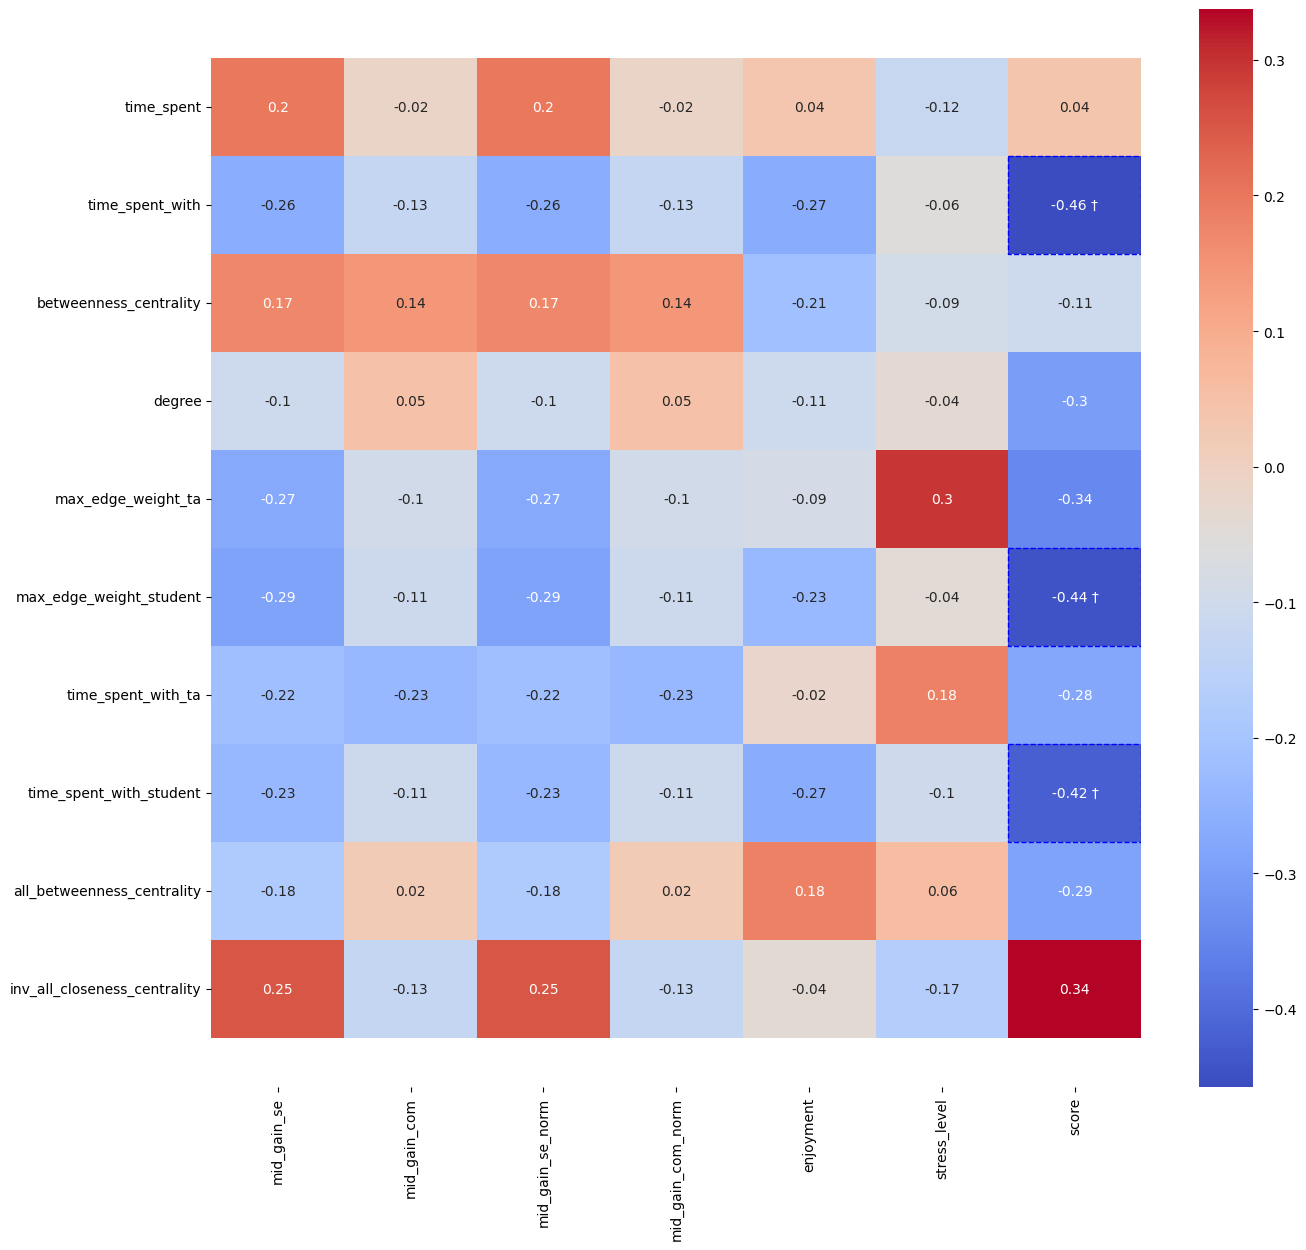

In [27]:
# define our predictors (rows) and outcomes (columns)
predictors = ['time_spent', 'time_spent_with', 'betweenness_centrality', 'degree', 'max_edge_weight_ta', 'max_edge_weight_student', 'time_spent_with_ta', 'time_spent_with_student', 'all_betweenness_centrality', 'inv_all_closeness_centrality']
outcomes = ['mid_gain_se', 'mid_gain_com', 'mid_gain_se_norm', 'mid_gain_com_norm', 'enjoyment','stress_level', 'score']

compute_correlation(merged_df, predictors, outcomes)

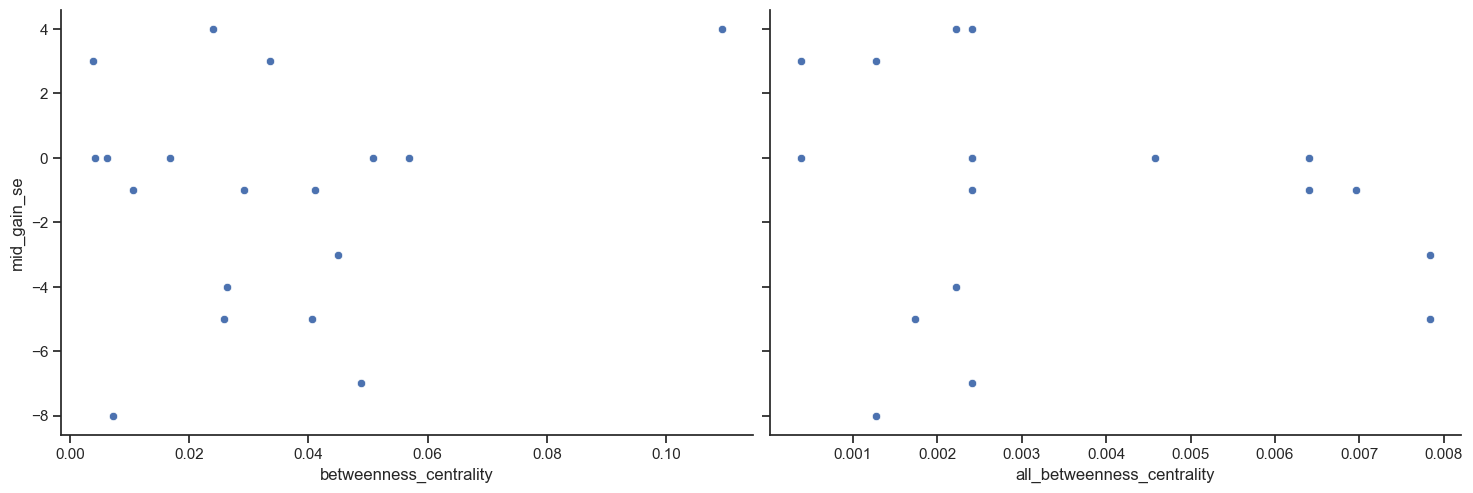

In [28]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(merged_df, y_vars='mid_gain_se', x_vars=['betweenness_centrality', 'all_betweenness_centrality'], height=5, aspect=1.5)

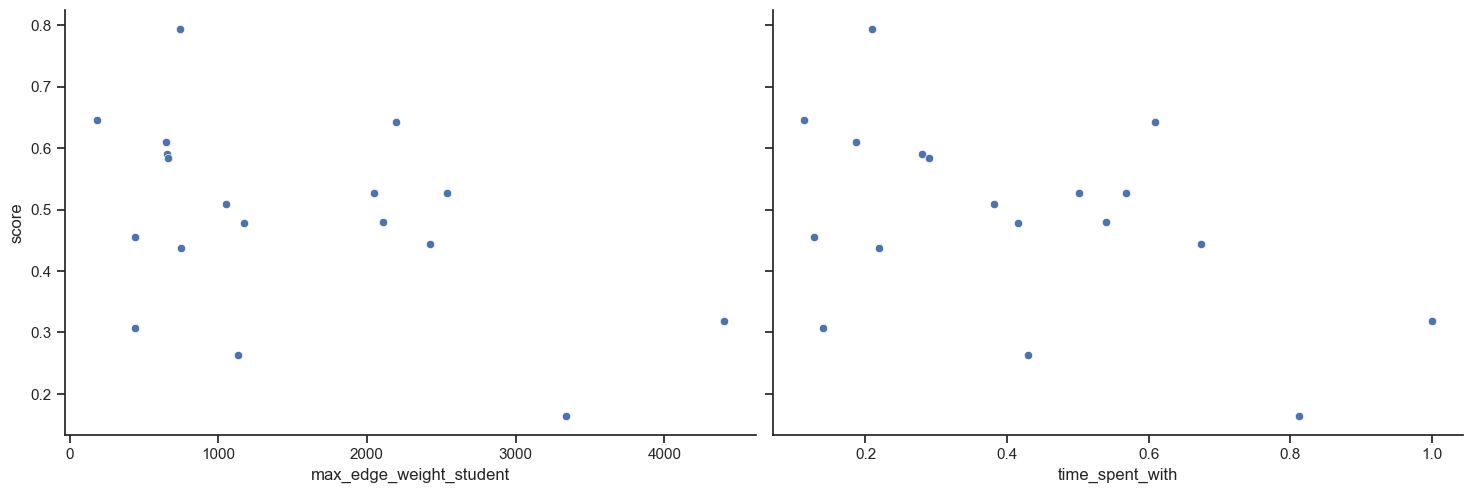

In [29]:
sns.pairplot(merged_df, y_vars='score', x_vars=['max_edge_weight_student', 'time_spent_with'], height=5, aspect=1.5)

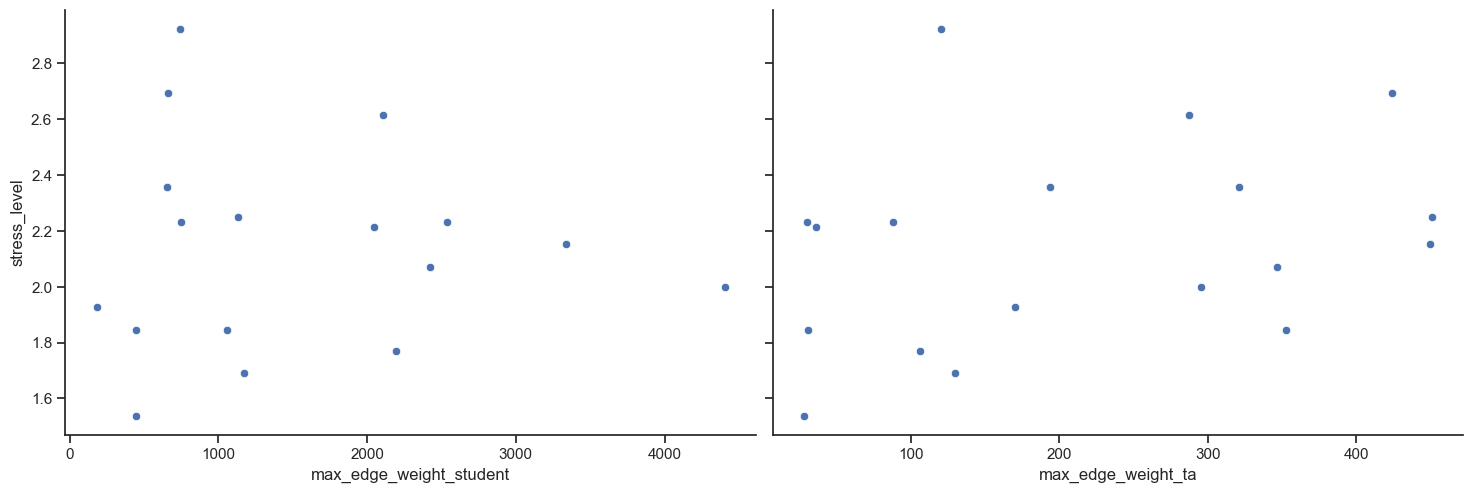

In [30]:
sns.set_theme(style="ticks")
sns.pairplot(merged_df, y_vars='stress_level', x_vars=['max_edge_weight_student', 'max_edge_weight_ta'], height=5, aspect=1.5)

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

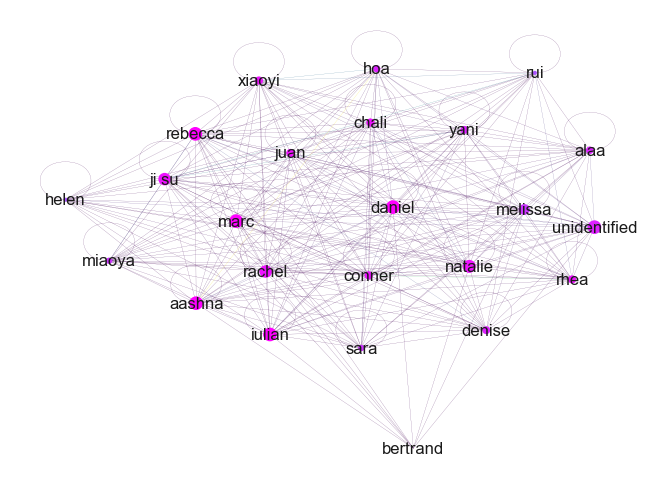

In [31]:

#Data Analysis
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(grouped_data, create_using=Graphtype, source='person_identity', target=state, edge_attr='is_with_count')
btc = nx.betweenness_centrality(G)
#ln2_list = list(grouped_data['is_with_count_ln2'])
cmap = plt.get_cmap('cool')
cmap2 = plt.get_cmap('viridis')
d = dict(nx.degree(G))
nx.spring_layout(G)
nx.draw(G, node_size=[v * 10000 for v in btc.values()], cmap = cmap, vmin = min(d.values()), vmax = max(d.values()), node_color=[v for v in d.values()], edge_cmap = cmap2, edge_color = [e[2]['is_with_count'] for e in G.edges(data=True)], with_labels=True, edge_vmin = min([e[2]['is_with_count'] for e in G.edges(data=True)]), edge_vmax = max([e[2]['is_with_count'] for e in G.edges(data=True)]), width = 0.1)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in G.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in G.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')

In [ ]:
#print(nx.prominent_group(G,2))
#print(nx.prominent_group(G,3))
#print(nx.prominent_group(G,4))
#print(nx.prominent_group(G,5))

In [ ]:
#nx.second_order_centrality(G)
#nx.clustering(G, weight='counts')


In [ ]:
nx.voterank(G,8)
nx.barycenter(G, weight='is_with_count')
community_list = nx.community.louvain_communities(G, weight='is_with_count')
print(community_list)

In [ ]:
node_t_s = time_spent_dat.set_index('person_identity').to_dict()['time_spent']
#is_with_ln2 = grouped_data.set_index('is_with_count_ln2').to_dict()['person_identity', 'is_oriented_toward']

nx.set_node_attributes(G, node_t_s, 'time_spent')
print(node_t_s)
tim_sp = nx.get_node_attributes(G, 'time_spent')
for all in tim_sp:
    print(nx.get_node_attributes(G, 'time_spent')[all])

In [ ]:
def dataplot(Group):
    btc = nx.betweenness_centrality(Group)
    tim_spent = []
    for all in nx.get_node_attributes(Group, 'time_spent'):
        tim_spent.append(nx.get_node_attributes(Group, 'time_spent')[all])
    cmap = plt.get_cmap('cool')
    cmap2 = plt.get_cmap('viridis')
    d = dict(nx.degree(Group))
    nx.spring_layout(Group)
    nx.draw(Group, node_size=[v * .003 for v in tim_spent ], cmap = cmap, vmin = min(btc.values()), vmax = max(btc.values()), node_color=[b for b in btc.values()], edge_cmap = cmap2, edge_color = [e[2]['is_with_count'] for e in Group.edges(data=True)], with_labels=True, edge_vmin = min([e[2]['is_with_count'] for e in Group.edges(data=True)]), edge_vmax = max([e[2]['is_with_count'] for e in Group.edges(data=True)]))
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
    cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in Group.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in Group.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')



dataplot(G)

#G_group1 = G.subgraph(community_list[0])
#G_group2 = G.subgraph(community_list[1])
#G_group3 = G.subgraph(community_list[2])
#G_group4 = G.subgraph(community_list[3])
#G_group5 = G.subgraph(community_list[4])


In [ ]:
dataplot(G_group1)

In [ ]:
dataplot(G_group2)

In [ ]:
dataplot(G_group3)

In [ ]:
dataplot(G_group4)

In [ ]:
dataplot(G_group5)